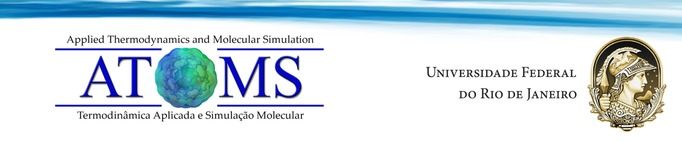

# Cálculo de ponto de formação de hidratos,
> estruturas s1 e s2
> usando equação de estado Peng-Robinson
> modelo de hidratos de van der Waals e Platteuw
> parâmetros de Munck et al.
> algoritmo Parrish-Prausnitz extendido:
> equilíbrio de hidrato e água líquida com gas, oleo ou gas+oleo
> algoritmo flash LV (Rachford-Rice) com estimativas de K-Wilson

### Autoria:
> Iuri Soter Viana Segtovich (pesquisador pós-doc junto ao EPQB\EQ\UFRJ no laboratório ATOMS)

* Supervisão
> prof. Frederico Wanderley Tavares

* Reconhecimento
> Material desenvolvido com reaproveitamento de códigos desenvolvidos em parceria com Fernando de Azevedo Medeiros (M.Sc.)

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#aux decorator
def paramclass(class1):
    #decorates a class for extending it by adding the paramdict method
    class class2(class1):
        def _paramdict_(self):
            #returns a dict from the classes attributes which do not start with underscore _
            keys=list(set(dir(self)))
            keys=[keysi for keysi in keys if keysi[0] != '_']
            values=[self.__getattribute__(keysi) for keysi in keys if keysi[0] != '_']
            return dict(zip(keys,values))
    return class2

# SETUP

In [3]:
#guests
Ncomp_g=8  
#                   0    1     2   3     4    5     6     7
cnames_g=np.array(['c1',   'co2',  'c2',     'n2',  'c3',   'ic4',  'nc4',   'h2s'])
tc_g=np.array([    190.555, 304.1, 305.3,    126.2, 369.8,  408.1,  425.1,   373.5]) #K
pc_g=np.array([    45.95e5, 73.8e5,48.714e5, 34e5,  42.48e5,36.48e5,37.96e5, 89.63e5]) #Pa
w_g=np.array([     0.008,   0.239, 0.099,    0.038, 0.152,  .181,   .2,      .094]) #dimensionless 
kij_g=np.zeros((Ncomp_g,Ncomp_g))
#set non-null kij:
#kij_g[0,2]=kij_g[2,0]=0.001 

#non guests
Ncomp_ng=4
#                    0      1     2     3  
cnames_ng=np.array(['benz','nc5','nc6','c7mais'])
tc_ng = np.array([562.,   469.7,  507.6,   540.2])        #<edit crtitical temperature for c7+
pc_ng = np.array([48.9e5, 33.7e5, 30.25e5, 27.4e5])      #<edit crtitical pressures for c7+
w_ng = np.array([0.212,  .252,   .301,     .35])        #<edit acentric factor for c7+
kij_ng=np.zeros((Ncomp_ng,Ncomp_ng))
#set non-null kij:
#kij_ng[0,2]=kij_ng[2,0]=0.001 

#pretoleum components
##mixture
Ncomp=Ncomp_g+Ncomp_ng
cnames=np.concatenate( (cnames_g,cnames_ng),axis=0)
tc=np.concatenate( (tc_g,tc_ng),axis=0)
pc=np.concatenate( (pc_g,pc_ng),axis=0)
w=np.concatenate( (w_g,w_ng),axis=0)

kij=np.zeros((Ncomp,Ncomp))
kij[:Ncomp_g,:Ncomp_g]=kij_g
kij[Ncomp_g:,Ncomp_g:]=kij_ng

#set non-null kij between guests_i and non-guests_j
#kij_ng[0,Ncomp_g+2]=kij_ng[Ncomp_g+2,0]=0.001 

#hydrate structure
@paramclass
class struc_s1():
    Ncav=2 #sI #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    UCnw = 46 #sI #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    ni = np.array([2/UCnw, 6/UCnw]) #sI #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    P0=612.62 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT
    T0=273.18 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT

    Dmu00 = 1264.00 #EL-LW  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    Dh00  = -4858.00 #EL-LW   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    Dcp00 = -39.16 #EL-LW   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure

    #VEL
    D_V_EL_Lw = 4.6e-6 #   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure


    Nguest=Ncomp_g
    A_pSWP = np.zeros([Nguest,Ncav])
    B_pSWP = np.zeros([Nguest,Ncav])

    #c1
    A_pSWP[0,0] = .7228e-8 #Pa^-1.K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    B_pSWP[0,0] = 3187. #K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    A_pSWP[0,1] = 23.35e-8 #Pa^-1.K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    B_pSWP[0,1] = 2653. #K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPU2*T components,structure

    #co2
    A_pSWP[1,0] = .2474e-8
    B_pSWP[1,0] = 3410.
    A_pSWP[1,1] = 42.46e-8
    B_pSWP[1,1] = 2813.

    #c2
    A_pSWP[2,0] = 0. #reallly zero
    B_pSWP[2,0] = 0. #reallly zero
    A_pSWP[2,1] = 3.039e-8
    B_pSWP[2,1] = 3861.

    #'n2'
    A_pSWP[3,0] = 1.617e-8
    B_pSWP[3,0] = 2905
    A_pSWP[3,1] = 6.078e-8
    B_pSWP[3,1] = 2431
    #'c3'
    A_pSWP[4,0] =  0.0
    B_pSWP[4,0] =  0.0
    A_pSWP[4,1] =  0.0
    B_pSWP[4,1] =  0.0
    #ic4'
    A_pSWP[5,0] = 0.
    B_pSWP[5,0] = 0.
    A_pSWP[5,1] = 0.
    B_pSWP[5,1] = 0.
    #'nc4'
    A_pSWP[6,0] = 0.
    B_pSWP[6,0] = 0.
    A_pSWP[6,1] = 0.
    B_pSWP[6,1] = 0.
    #'h2s'
    A_pSWP[7,0] =  0.0250e-8
    B_pSWP[7,0] =  4568
    A_pSWP[7,1] =  16.34e-8
    B_pSWP[7,1] =  3737
    
@paramclass
class struc_s2():
    Ncav=2 #sII #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    UCnw =136 #sII #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    ni = np.array([16/UCnw, 8/UCnw]) #sII #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

    P0=612.62 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT
    T0=273.18 #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT

    Dmu00 = 883.00 #EL-LW  #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    Dh00  = -5201.00 #EL-LW   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure
    Dcp00 = -39.16 #EL-LW   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure

    #VEL
    D_V_EL_Lw = 5.0e-6 #   #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT structure


    Nguest=Ncomp_g
    A_pSWP = np.zeros([Nguest,Ncav])
    B_pSWP = np.zeros([Nguest,Ncav])

    #c1
    A_pSWP[0,0] = .2207e-8 #Pa^-1.K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    B_pSWP[0,0] = 3453. #K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    A_pSWP[0,1] = 100.e-8 #Pa^-1.K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPUT components,structure
    B_pSWP[0,1] = 1916. #K #<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<INPU2*T components,structure

    #co2
    A_pSWP[1,0] = .0845e-8
    B_pSWP[1,0] = 3615.
    A_pSWP[1,1] = 851.e-8
    B_pSWP[1,1] = 2025.

    #c2
    A_pSWP[2,0] = 0. #reallly zero
    B_pSWP[2,0] = 0. #reallly zero
    A_pSWP[2,1] = 240.e-8
    B_pSWP[2,1] = 2967.
    
    #'n2'
    A_pSWP[3,0] =  0.1742e-8
    B_pSWP[3,0] =  3082
    A_pSWP[3,1] =  18.00e-8
    B_pSWP[3,1] =  1728
    #'c3'
    A_pSWP[4,0] =  0.0
    B_pSWP[4,0] =  0.0
    A_pSWP[4,1] =  5.455e-8
    B_pSWP[4,1] =  4638
    #ic4'
    A_pSWP[5,0] = 0.
    B_pSWP[5,0] = 0.
    A_pSWP[5,1] =  189.3e-8
    B_pSWP[5,1] =  3800
    #'nc4'
    A_pSWP[6,0] = 0.
    B_pSWP[6,0] = 0.
    A_pSWP[6,1] =  30.51e-8
    B_pSWP[6,1] =  3699
    #'h2s'
    A_pSWP[7,0] =  0.0298e-8
    B_pSWP[7,0] =  4878
    A_pSWP[7,1] =  87.2e-8
    B_pSWP[7,1] =  2633
    
#unit system / physical constants
R = 8.3144598 #m^3*Pa/(mol*K)

In [4]:
struc_s1()._paramdict_()

{'UCnw': 46,
 'ni': array([0.04347826, 0.13043478]),
 'Dh00': -4858.0,
 'D_V_EL_Lw': 4.6e-06,
 'Nguest': 8,
 'B_pSWP': array([[3187., 2653.],
        [3410., 2813.],
        [   0., 3861.],
        [2905., 2431.],
        [   0.,    0.],
        [   0.,    0.],
        [   0.,    0.],
        [4568., 3737.]]),
 'Dcp00': -39.16,
 'T0': 273.18,
 'Ncav': 2,
 'A_pSWP': array([[7.228e-09, 2.335e-07],
        [2.474e-09, 4.246e-07],
        [0.000e+00, 3.039e-08],
        [1.617e-08, 6.078e-08],
        [0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00],
        [0.000e+00, 0.000e+00],
        [2.500e-10, 1.634e-07]]),
 'P0': 612.62,
 'Dmu00': 1264.0}

In [5]:
struc_s2()._paramdict_()

{'UCnw': 136,
 'ni': array([0.11764706, 0.05882353]),
 'Dh00': -5201.0,
 'D_V_EL_Lw': 5e-06,
 'Nguest': 8,
 'B_pSWP': array([[3453., 1916.],
        [3615., 2025.],
        [   0., 2967.],
        [3082., 1728.],
        [   0., 4638.],
        [   0., 3800.],
        [   0., 3699.],
        [4878., 2633.]]),
 'Dcp00': -39.16,
 'T0': 273.18,
 'Ncav': 2,
 'A_pSWP': array([[2.207e-09, 1.000e-06],
        [8.450e-10, 8.510e-06],
        [0.000e+00, 2.400e-06],
        [1.742e-09, 1.800e-07],
        [0.000e+00, 5.455e-08],
        [0.000e+00, 1.893e-06],
        [0.000e+00, 3.051e-07],
        [2.980e-10, 8.720e-07]]),
 'P0': 612.62,
 'Dmu00': 883.0}

# EOS

In [6]:
_R=R
class c_vEoS(): #Peng Robinson
    def __init__(self,ncomp,Tc,Pc,acentric,k): #roda uma vez para carregar as propriedades por componentes
        #Array dimensioning info
        self.ncomp = ncomp
        #vEoS specific parameters 
        self.sigma = 1.0 + np.sqrt(2.)
        self.epsilon = 1.0 - np.sqrt(2.)
        self.ac = np.zeros(self.ncomp)
        self.bc = np.zeros(self.ncomp)
        self.k = np.zeros([self.ncomp,self.ncomp])
        
        #Extracted pure component properties
        self.Tc = np.zeros(self.ncomp) #needed at every alpha updating
        self.Pc = np.zeros(self.ncomp) #not really needed after initialization
        self.acentric = np.zeros(self.ncomp) #needed at every alpha updating
        
        self.kPR = np.zeros(self.ncomp) #needed at every alpha updating
        
        for i in range(self.ncomp):
            self.Tc[i]                     = Tc[i]
            self.Pc[i]                     = Pc[i]
            self.acentric[i]         = acentric[i]
        
        for i in range(self.ncomp):
            self.ac[i]                     = 0.45724*(_R**2)*((self.Tc[i])**2)/(self.Pc[i])
            self.bc[i]                     = 0.07780*_R*(self.Tc[i])/(Pc[i])

            for j in range(self.ncomp):
                self.k[i,j]                = k[i,j]
                
            self.kPR[i]                    = 0.37464 + 1.54226*acentric[i]-0.26992*(acentric[i])**2
                
        return #NoneTypeObj

    def Pressure(self,T,V,x):
        bm=self._f_bmix(x)
        Aalpham,Aalpha=self._f_Aalphamix(T,x)
        P = (_R*T)/(V-bm) - Aalpham/(V**2 + 2*bm*V - bm**2) #sigma & epsilon hardcoded here
        return P

    def _f_Aalpha(self,T,x):
        alpha=np.zeros(self.ncomp)
        Aalpha=np.zeros(self.ncomp)
        for i in range(self.ncomp):
            alpha[i] = (1. +self.kPR[i]*(1.-np.sqrt(T/self.Tc[i])))**2
            Aalpha[i] = self.ac[i]*alpha[i]
        return Aalpha

    def _f_bmix(self,x):
        bm = 0.
        for i in range(self.ncomp):
            bm += x[i]*self.bc[i]
        return bm
        
    def _f_Aalphamix(self,T,x):
        Aalpha=self._f_Aalpha(T,x)
        Aalpham = 0.
        for i in range(self.ncomp):
            for j in range(self.ncomp):
                Aalpham += x[i]*x[j]*np.sqrt(Aalpha[i]*Aalpha[j])*(1.-self.k[i,j])
        return Aalpham, Aalpha
     
    def _f_dbdn(self,x):
        bm=self._f_bmix(x)
        dbdn=np.zeros(self.ncomp)
        for i in range(self.ncomp):
            dbdn[i]=self.bc[i]
        return dbdn, bm
        
    def _f_dAalphadn(self,T,x):
        Aalpham, Aalpha = self._f_Aalphamix(T,x)
        dAalphadn = np.zeros(self.ncomp)
        sum1 = 0.
        for i in range(self.ncomp):
            sum1 = 0.
            for j in range(self.ncomp):
                sum1 += x[j]*np.sqrt(Aalpha[j])*(1.-self.k[i,j])
            dAalphadn[i]=np.sqrt(Aalpha[i])*sum1
        return dAalphadn, Aalpham

    def Volume(self,T,P,x):
    # T em unidade K
    # P em unidade Pa
    # x array normalizado

        bm=self._f_bmix(x)
        Aalpham,_=self._f_Aalphamix(T,x)

        c3 = 1.                                                                # Coeficiente para V^3 para EoS PR
        c2 = bm - _R*T/P                                                # Coeficiente para V^2 para EoS PR
        c1 = Aalpham/P - 3.*(bm**2) - 2.*bm*_R*T/P     # Coeficiente para V^1 para EoS PR
        c0 = (_R*T*bm**2)/P + bm**3 - Aalpham*bm/P    # Termo independente para EoS PR
        
#        sigma=1+np.sqrt(2)
#        epsilon=1-np.sqrt(2)
#        c0 = -(bm**3)*sigma*epsilon + (-_R*T*sigma*epsilon*(bm**2)-bm*Aalpham)/P
#        c1 = (bm**2)*(sigma*epsilon-epsilon-sigma) + ((_R*T)*(-sigma*bm-epsilon*bm) + Aalpham)/P
#        c2 = epsilon*bm+sigma*bm-bm-_R*T/P
#        c3 = 1.
#        print("cs",c3,c2,c1,c0)
        
        Vs=np.roots([c3,c2,c1,c0])
        Vs[np.logical_not(np.isreal(Vs))]=0.
        Vs=np.real(Vs)
        return np.array([np.nanmin(Vs[Vs>bm]),np.nanmax(Vs[Vs>bm])])

    #phase equilibrium common
    def fugacity_coeff(self,T,V,x): #for a vdw1f mixrule cubic eos with sigma!=epsilon
        P=self.Pressure(T,V,x)
        dbdn,bm = self._f_dbdn(x)
        dAalphadn, Aalpham = self._f_dAalphadn(T,x)
        qsi = (1./(bm*(self.epsilon-self.sigma)))*np.log((V+self.epsilon*bm)/(V+self.sigma*bm))
        lnPhi = np.zeros(self.ncomp)
        for i in range(self.ncomp):
            lnPhi[i] = ( #multiline
                (dbdn[i]/bm)*((P*V)/(_R*T)-1.) #&
                -np.log(P*(V-bm)/(_R*T)) #&
                -(Aalpham/(_R*T))*qsi*((2.*dAalphadn[i]/Aalpham) #&
                -(dbdn[i]/bm))
                                 )#done
        phi = np.exp(lnPhi)
        return phi

    def _f_dAalphadT(self,T,x):
        dalphadT=np.zeros(self.ncomp)
        dAalphadT=np.zeros(self.ncomp)
        for i in range(self.ncomp):
            #alpha[i] = (1. + self.kPR[i]*(1.-np.sqrt(T/self.Tc[i])))**2
            dalphadT[i] = ( #multiline
                2.*(1. + self.kPR[i]*(1.-np.sqrt(T/self.Tc[i])))*
                self.kPR[i]*(-1.)*(
                1./(2.*(np.sqrt(T/self.Tc[i])))
                )*(1./self.Tc[i])
            )
            dAalphadT[i] = self.ac[i]*dalphadT[i]
        return dAalphadT

    def _f_dAalphamdT(self,T,x):
        _, Aalpha=self._f_Aalphamix(T,x)
        dAalphadT=self._f_dAalphadT(T,x)

        dAalphamdT = 0.
        for i in range(self.ncomp):
            for j in range(self.ncomp):
                dAalphamdT += ( #multiline
                    x[i]*x[j]*
                    (1./(2.*np.sqrt(Aalpha[i]*Aalpha[j])))*
                    (Aalpha[i]*dAalphadT[j]+dAalphadT[i]*Aalpha[j])*
                    (1.-self.k[i,j])
                )
        #print(dAalphamdT)
        #numerical
        #AalphammaisT,_=self._f_Aalphamix(T+1e-3,x)
        #AalphammenosT,_=self._f_Aalphamix(T-1e-3,x)
        #dAalphamdT=(AalphammaisT-AalphammenosT)/(2.*1e-3)
        #print(dAalphamdT)
        return dAalphamdT

    #other spec flashes
    def f_H_res(self,T,V,x):
        P=self.Pressure(T,V,x)
        bm=self._f_bmix(x)
        dAalphamdT = self._f_dAalphamdT(T,x)
        Aalpham, _ = self._f_Aalphamix(T,x)
        qsi = (1./(bm*(self.epsilon-self.sigma)))*np.log((V+self.epsilon*bm)/(V+self.sigma*bm)) #again
        H_res = P*V - _R*T + (T*dAalphamdT-Aalpham)*qsi
#        print(Aalpham)
        return H_res

    def f_S_res(self,T,V,x):
        P=self.Pressure(T,V,x)
        bm=self._f_bmix(x)
        dAalphamdT = self._f_dAalphamdT(T,x)
        Aalpham, Aalpha = self._f_Aalphamix(T,x)
        qsi = (1./(bm*(self.epsilon-self.sigma)))*np.log((V+self.epsilon*bm)/(V+self.sigma*bm)) #again
        S_res = _R*np.log((P*(V-bm))/(_R*T)) + dAalphamdT*qsi
        return S_res
print(Ncomp)    
eosPR=c_vEoS(ncomp=Ncomp,Tc=tc,Pc=pc,acentric=w,k=kij)

12


In [7]:
str(cnames)

"['c1' 'co2' 'c2' 'n2' 'c3' 'ic4' 'nc4' 'h2s' 'benz' 'nc5' 'nc6' 'c7mais']"

In [8]:
zgas=np.array([58.77, .93, 7.57, .21, 4.09, .91, 2.09, 0., 0., .77+1.15, 1.75, 21.76 ])/100

In [9]:
#tests
testV=eosPR.Volume(T=273,P=1e5,x=zgas)
print( testV )
print( eosPR.fugacity_coeff(T=273,V=testV[0],x=zgas) )

testV = eosPR.Volume(T=273,P=1e8,x=zgas)
print( testV )
print( eosPR.fugacity_coeff(T=273,V=testV[1],x=zgas) )

[8.82312739e-05 2.23147465e-02]
[9.34989138e+01 2.49817191e+01 1.68150391e+01 2.39408420e+02
 4.46192250e+00 1.64761625e+00 1.18911033e+00 1.27110164e+01
 1.28757865e-01 3.23961001e-01 9.05516287e-02 2.57028844e-02]
[6.54725105e-05 6.54725105e-05]
[0.81556049 0.15274258 0.20488908 2.27431253 0.094572   0.0673112
 0.04479654 0.06624548 0.00302159 0.02389096 0.01367315 0.00825676]


# FLASH

In [10]:
class c_FlashLV():
    ''' liquid vapor flash'''
    
    def __init__(self):
        return

    #Eq. 1 - The Rachford-Rice residue function
    def RES_RR(self,Ncomp,z,K,BETA):
        import numpy as np
        RES = 0.
        for i in range(Ncomp):
            RES += z[i]*( (K[i]-1.) / (1.+BETA*(K[i]-1.)) )            
        return RES

    def Newton(self,Ncomp,z,K,BETA):
        import numpy as np
        RES=1
        TOL=1e-9
        MAXi=100
        i=0
        while (np.abs(RES)>TOL and i < MAXi):
            RES=self.RES_RR(Ncomp,z,K,BETA)
            step=1e-5
            JAC=(self.RES_RR(Ncomp,z,K,BETA+step)-self.RES_RR(Ncomp,z,K,BETA-step))/(2*step)
            BETA-=RES/JAC
            i+=1
    #        print(i)
        return BETA
        
    def update_x(self,Ncomp,z,K,BETA):
        import numpy as np
        x=np.zeros(Ncomp)
        y=np.zeros(Ncomp)
        for i in range(Ncomp):
            x[i] = z[i]*( (1.) / (1+BETA*(K[i]-1.)) )            
            y[i] = K[i]*x[i]
        return x/np.sum(x), y/np.sum(y)

    def flash_TP(self,Ncomp,T,P,z,K,BETA,eos):
        import numpy as np
        RES_flash=1
        TOL=1e-9
        #print('P',P)
        while (np.abs(RES_flash)>TOL):
            #print(K)
            K_ol=1.*K #copy
            #given K,calc BETA
            BETA=self.Newton(Ncomp,z,K,BETA)
            #print(BETA)
            if BETA>1:
                return z,z,2
            elif BETA<0:
                return z,z,-1
            else:
                pass 
            
            #given K,BETA calc x
            x,y=self.update_x(Ncomp,z,K,BETA)
    #        print("x=",x)
    #        print("y=",y)
            #given x calc fugacity_coeffs
            VL=eos.Volume(T=T,P=P,x=x)[0] #expecting 2 sorted physically meaningful roots 
            VV=eos.Volume(T=T,P=P,x=y)[1] #expecting 2 sorted physically meaningful roots 
    #         print(VL,VV)
            phiL=eos.fugacity_coeff(T=T,V=VL,x=x)
            phiV=eos.fugacity_coeff(T=T,V=VV,x=y)
    #         print(phiL,phiV)
            #update K
            K=phiL/phiV #update K
    #         print(K_ol)
    #         print(K)
            RES_flash=np.linalg.norm(K_ol-K)
    #         print(RES_flash)
        return x,y,BETA
    
flashLV = c_FlashLV()

In [11]:
T=250
P=1.e5
Kguess = np.exp(np.log(pc/P)+5.373*(1.+w)*(1.-tc/T)) #Wilson https://books.google.com.br/books?id=UTuIDwAAQBAJ&pg=PA29&lpg=PA29&dq=wilson+5.373+tc+pc&source=bl&ots=WtXwdVzEaH&sig=ACfU3U1AsNlROUpBOq_SNouW2IGw0gnf3A&hl=pt-BR&sa=X&ved=2ahUKEwi-_LX3vp_oAhUnHbkGHX6jClsQ6AEwAHoECAoQAQ#v=onepage&q=wilson%205.373%20tc%20pc&f=false
PSATapprox = P*Kguess
print( PSATapprox )
x,y,BETA = flashLV.flash_TP(Ncomp=Ncomp,T=T,P=P,z=zgas,K=Kguess,BETA=.5,eos=eosPR)
x,y,BETA

[1.66561819e+07 1.74746651e+06 1.31944543e+06 5.38171396e+07
 2.18787566e+05 6.59589072e+04 4.15045940e+04 4.91320981e+05
 1.44466395e+03 9.12469011e+03 2.25215846e+03 6.03983958e+02]


(array([7.02403881e-03, 8.30509741e-04, 8.80225148e-03, 6.73259748e-06,
        2.24453075e-02, 1.21466498e-02, 3.70307782e-02, 0.00000000e+00,
        0.00000000e+00, 5.81023269e-02, 6.15492123e-02, 7.92062193e-01]),
 array([0.8047332 , 0.01246555, 0.10070367, 0.00288238, 0.04779762,
        0.00796129, 0.01487097, 0.        , 0.        , 0.00465988,
        0.00103618, 0.00288925]),
 0.7279294095799381)

In [12]:
T=250
P=1.e9
Kguess = np.exp(np.log(pc/P)+5.373*(1.+w)*(1.-tc/T)) #Wilson https://books.google.com.br/books?id=UTuIDwAAQBAJ&pg=PA29&lpg=PA29&dq=wilson+5.373+tc+pc&source=bl&ots=WtXwdVzEaH&sig=ACfU3U1AsNlROUpBOq_SNouW2IGw0gnf3A&hl=pt-BR&sa=X&ved=2ahUKEwi-_LX3vp_oAhUnHbkGHX6jClsQ6AEwAHoECAoQAQ#v=onepage&q=wilson%205.373%20tc%20pc&f=false
PSATapprox = P*Kguess
print( PSATapprox )
x,y,BETA = flashLV.flash_TP(Ncomp=Ncomp,T=T,P=P,z=zgas,K=Kguess,BETA=.5,eos=eosPR)
x,y,BETA #-1 means liq

[1.66561819e+07 1.74746651e+06 1.31944543e+06 5.38171396e+07
 2.18787566e+05 6.59589072e+04 4.15045940e+04 4.91320981e+05
 1.44466395e+03 9.12469011e+03 2.25215846e+03 6.03983958e+02]


(array([0.5877, 0.0093, 0.0757, 0.0021, 0.0409, 0.0091, 0.0209, 0.    ,
        0.    , 0.0192, 0.0175, 0.2176]),
 array([0.5877, 0.0093, 0.0757, 0.0021, 0.0409, 0.0091, 0.0209, 0.    ,
        0.    , 0.0192, 0.0175, 0.2176]),
 -1)

In [13]:
T=250
P=1.e3
Kguess = np.exp(np.log(pc/P)+5.373*(1.+w)*(1.-tc/T)) #Wilson https://books.google.com.br/books?id=UTuIDwAAQBAJ&pg=PA29&lpg=PA29&dq=wilson+5.373+tc+pc&source=bl&ots=WtXwdVzEaH&sig=ACfU3U1AsNlROUpBOq_SNouW2IGw0gnf3A&hl=pt-BR&sa=X&ved=2ahUKEwi-_LX3vp_oAhUnHbkGHX6jClsQ6AEwAHoECAoQAQ#v=onepage&q=wilson%205.373%20tc%20pc&f=false
PSATapprox = P*Kguess
print( PSATapprox )
x,y,BETA = flashLV.flash_TP(Ncomp=Ncomp,T=T,P=P,z=zgas,K=Kguess,BETA=.5,eos=eosPR)
x,y,BETA #2 means vapor

[1.66561819e+07 1.74746651e+06 1.31944543e+06 5.38171396e+07
 2.18787566e+05 6.59589072e+04 4.15045940e+04 4.91320981e+05
 1.44466395e+03 9.12469011e+03 2.25215846e+03 6.03983958e+02]


(array([0.5877, 0.0093, 0.0757, 0.0021, 0.0409, 0.0091, 0.0209, 0.    ,
        0.    , 0.0192, 0.0175, 0.2176]),
 array([0.5877, 0.0093, 0.0757, 0.0021, 0.0409, 0.0091, 0.0209, 0.    ,
        0.    , 0.0192, 0.0175, 0.2176]),
 2)

# HYD

In [14]:
class HYD():
    def __init__(self,UCnw, A_pSWP, Dmu00, Ncav, D_V_EL_Lw, Dh00, B_pSWP, T0, Nguest, P0, Dcp00, ni):
        self.UCnw = UCnw
        self.A_pSWP = A_pSWP
        self.Dmu00 = Dmu00
        self.Ncav = Ncav
        self.D_V_EL_Lw = D_V_EL_Lw
        self.Dh00 = Dh00
        self.B_pSWP = B_pSWP
        self.T0 = T0
        self.Nguest = Nguest
        self.P0 = P0
        self.Dcp00 = Dcp00
        self.ni = ni
        return
    
    def vdwnp_H_EL(self,T,fug):
        #LANGMUIR CONSTANTS
        Clang=np.zeros([self.Nguest,self.Ncav])
        for i in range(self.Nguest):
            for j in range(self.Ncav):
                Clang[i,j] = (self.A_pSWP[i,j]/T)*np.exp(self.B_pSWP[i,j]/T) #Pa
                
        #OCCUPANCY
        occ=np.zeros([self.Nguest,self.Ncav])
        for j in range(self.Ncav):
            sum1 = 0.      
            for i in range(self.Nguest):
                sum1 += Clang[i,j]*fug[i]

            for i in range(self.Nguest):
                occ[i,j] = Clang[i,j]*fug[i]/(1.+sum1)         
        #vdwnp
        Dmu_H_EL = 0.
        for j in range(self.Ncav):
            sum1 = 0.
            for i in range(self.Nguest):
                sum1 += occ[i,j]

            Dmu_H_EL += self.ni[j]*np.log(1.-sum1)

        return Dmu_H_EL

    def saito_EL_Lw(self,T,P):

        #-S_DH_EL_LW_RT2_dT (T0->T, P)
        GenVantHoffFactor = (1./R) * (((1./T)-(1/self.T0))*(self.Dh00-self.Dcp00*self.T0) - (self.Dcp00)*np.log(T*(1/self.T0)))

        #Poyinting_EL_Lw (T, P0->P)
        Poynting_EL_Lw = self.D_V_EL_Lw*(P-self.P0)/(R*T)

        Dmu_EL_Lw = ( self.Dmu00/(R*self.T0) + GenVantHoffFactor + Poynting_EL_Lw ) #EL-PW

        return Dmu_EL_Lw
    
HYDs1=HYD(**(struc_s1()._paramdict_()))
HYDs2=HYD(**(struc_s2()._paramdict_()))

# SOLVE HYDincipient+LVflash

In [15]:
#calc_hyd
from scipy.optimize import bisect as SOLVE
from scipy.optimize import root as ROOT

#definition of residue function for numerical solution along the PxT phase diagram
def RES(T,P,HYDs):


    #solve ELV to find fugacities if ncomp>=2
    Kguess = np.exp(np.log(pc/P)+5.373*(1.+w)*(1.-tc/T)) #Wilson
    x,y,BETA = flashLV.flash_TP(Ncomp=Ncomp,T=T,P=P,z=zgas,K=Kguess,BETA=.5,eos=eosPR)

    #test monophase

    #print(BETA)

    if BETA>1: #2
        #gas
        composition=zgas
        ivol=1
    elif 0<BETA<1:
        composition=y
        ivol=1
    elif BETA<0: #-1
        composition=zgas
        ivol=0



    #run hydrate model:      
    Dmu_EL_Lw=HYDs.saito_EL_Lw(T,P)

    VOLfluid = eosPR.Volume(T=T,P=P,x=composition)
    fug_G = composition * P * eosPR.fugacity_coeff(T=T,V=VOLfluid[ivol],x=composition)
    #print(fug_G)
    Dmu_H_EL=HYDs.vdwnp_H_EL(T,fug_G[:HYDs.Nguest]) #use only fugacities for the first  nguest  componentes


    return Dmu_EL_Lw+Dmu_H_EL

In [16]:
#cálculo de formação em condição Pspec isolada
#> #define a lambda function for thew numerical method so that the numerical method can treat the RES of T and P as a function of 1 variable and tehrefore provide solutions for T for each given P
Pspec=1e7
#s1
ans=ROOT(   lambda T, P=Pspec: RES(T,P,HYDs1), [300])
print('s1: ',ans)
#s2
ans=ROOT( lambda T, P=Pspec: RES(T,P,HYDs2), [300] )
print('s2: ',ans)

s1:      fjac: array([[-1.]])
     fun: array([-6.48370246e-14])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.40109816e-08])
       r: array([-0.01376313])
  status: 1
 success: True
       x: array([287.11018443])
s2:      fjac: array([[-1.]])
     fun: array([-5.54001289e-14])
 message: 'The solution converged.'
    nfev: 6
     qtf: array([-1.14074463e-08])
       r: array([-0.01429412])
  status: 1
 success: True
       x: array([291.10247005])


In [17]:
#define a script to calculate the phase diagram
def calcPhaseDiagram():
    
    #define a grid
    npoints=20
    Tgrid1 = np.zeros(npoints)
    Tgrid2 = np.zeros(npoints)
    Pgrid = np.logspace(5,8,npoints)
    
    #seek solution for T for each P in the grid
    for i in range(npoints):

        #call the solver imported from scipy.optimize
        ans=ROOT(
            #define a lambda function for thew numerical method
            #so that the numerical method can treat the RES of T and P as a function of 1 variable and tehrefore provide solutions for T for each given P
            lambda T, P=Pgrid[i]: RES(T,P,HYDs1), [300])
        ans=ans['x']
    #record solution after each point in the grid
        Tgrid1[i]=ans[0]
        
        #call the solver imported from scipy.optimize
        ans=ROOT(
            #define a lambda function for thew numerical method
            #so that the numerical method can treat the RES of T and P as a function of 1 variable and tehrefore provide solutions for T for each given P
            lambda T, P=Pgrid[i]: RES(T,P,HYDs2), [300])
        ans=ans['x']
    #record solution after each point in the grid
        Tgrid2[i]=ans[0]
        
        print(i,Pgrid[i],Tgrid1[i],Tgrid2[i])

    #plot:
    return Tgrid1,Tgrid2,Pgrid

In [18]:
def plotPhaseDiagram(xlim=None,ylim=None,xexp=None,yexp=None):
    #activate figure
    #plot calculated data
    fig=plt.figure(figsize=[5,4])
    ax=fig.add_axes([.1,.1,.8,.8],label='1')
    ax.plot(Tgrid1,Pgrid,label='s1')
    ax.plot(Tgrid2,Pgrid,label='s2')
    
    #set plot limits
    if xlim is None:
        xlim=(270,320)
    ax.set_xlim(*xlim)
    if ylim is None:
        ylim = (1e4,1e8)
    ax.set_ylim(*ylim)
    
    ax.set_yscale('log')

    #Let's also plot some experimental data along our calculations
    
    #retrieve data from a text file provided with this notebook
#     table = np.loadtxt('C1-sI-hydrates-HLwGequilibria-expData.txt', #data from NIST
#                        dtype='float', 
#                        comments='#', 
#                        converters=None,
#                        skiprows=0,
#                        usecols=None,
#                        unpack=False,
#                        ndmin=0)
    
    #split data into arrays for T and P
    #T_eq = table[:,0]
    #P_eq = table[:,1]    
    
    #plot exp data as scatter
    #plt.scatter(T_eq,P_eq)
    
    #format
    ax.set_title(',  '.join(cnames)+'\n'+str(zgas*100)+'%',pad=20)
    ax.set_xlabel(r'$T\mathrm{(K)}$')
    ax.set_ylabel(r'$P\mathrm{(Pa)}$')

    
    #MMM=plt.imread('data/ic4.png')
    #print(MMM.shape)
    #ax2=fig.add_axes([.1,.1,.8,.8],label='2')
    #ax2.set_xlim(0,500)
    #ax2.set_ylim(0,500)
    #ax2.imshow(MMM,alpha=.5)
    #ax2.patch.set_alpha(0)
    #show plot!
    fig.legend(loc='center right')
    #fig.savefig('ic4_out.png')
    plt.show()    
    return

In [19]:
#call the phase diagram script
Tgrid1,Tgrid2,Pgrid=calcPhaseDiagram()

0 100000.0 247.07466466134923 261.5528046091321
1 143844.9888287663 250.28223948184453 263.7861698116532
2 206913.808111479 253.54619927863303 266.09022991570004
3 297635.14416313195 256.85682675872204 268.46100954457086
4 428133.2398719396 260.20119918755114 270.8908807108184
5 615848.2110660267 263.5626405216965 273.36838934963794
6 885866.7904100833 266.92041952096594 275.878092477976
7 1274274.985703132 270.2499074510429 278.4000113764772
8 1832980.7108324375 273.52331668076795 280.90821016710277
9 2636650.8987303553 276.7107647551393 283.3682900931645
10 3792690.1907322537 279.7807111235701 285.73433599247795
11 5455594.781168515 282.69844036086283 287.9469032622708
12 7847599.703514607 285.4231576385383 289.9354262721769
13 11288378.916846883 287.9104764667003 291.63303950350576
14 16237767.391887208 289.76079187816333 292.948064140353
15 23357214.690901212 291.12112989138797 294.20902635359215
16 33598182.862837814 292.7780874421206 295.7898111163375
17 48329302.38571752 294.781

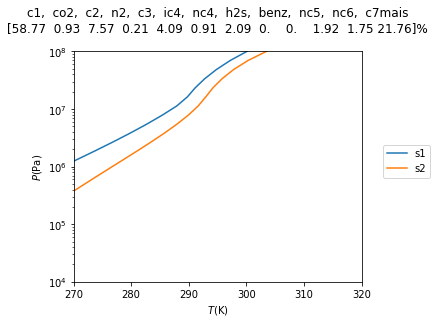

In [20]:
plotPhaseDiagram()

In [34]:
def flash_PBeta(T,P,z,BETA,K,Ncomp,eos):
    RES_flash=1
    TOL=1e-10
    MAXj=100
    j=0
    while (np.abs(RES_flash)>TOL and j < MAXj):
        K_ol=1.*K
        x,y=update_x(z,K,BETA,Ncomp)
        T=Newton_T(z,K,BETA,P,x,y,Ncomp,T,eos)
        K = update_K(T,P,x,y,eos)
        RES_flash=np.linalg.norm(K_ol-K)
        j+=1
        #print(RES_flash,j)
    return x,y,K,T,j

def Newton_T(z,K,BETA,P,x,y,Ncomp,T,eos):
    RES=1
    TOL=1e-8
    MAXi=100
    i=0
    while (np.abs(RES)>TOL and i < MAXi):
        RES=RES_RR_T(z,K,BETA,P,x,y,Ncomp,T,eos)
        step=1e-5
        JAC=(RES_RR_T(z,K,BETA,P,x,y,Ncomp,T+step,eos)-RES_RR_T(z,K,BETA,P,x,y,Ncomp,T-step,eos))/(2*step)
        T-=RES/JAC
        i+=1
    return T

def update_x(z,K,BETA,Ncomp):
    x=np.zeros(Ncomp)
    y=np.zeros(Ncomp)
    for i in range(Ncomp):
        x[i] = z[i]*( (1.) / (1+BETA*(K[i]-1.)) )            
        y[i] = K[i]*x[i]
    return x/np.sum(x), y/np.sum(y)

def update_K(T,P,x,y,eos):
    VL=eos.Volume(T=T,P=P,x=x)[0]
    VV=eos.Volume(T=T,P=P,x=y)[1] 

    phiL=eos.fugacity_coeff(T=T,V=VL,x=x)
    phiV=eos.fugacity_coeff(T=T,V=VV,x=y)

    K=phiL/phiV
    return K

def RES_RR_T(z,K,BETA,P,x,y,Ncomp,T,eos):   
    RES = 0.
    K = update_K(T,P,x,y,eos)
    for i in range(Ncomp):
        RES += z[i]*( (K[i]-1.) / (1.+BETA*(K[i]-1.)) )            
    return RES
  
print("ok")

ok


In [35]:
ngrid=300
P_grid = np.zeros(ngrid)
iterations = np.zeros(ngrid)
BETA = 1. #0.99
T_guess = 200

P_grid[0] = 5e5
P_grid[1] = 5.5e5

delta_T = 2

x = np.zeros([ngrid,Ncomp])
y = np.zeros([ngrid,Ncomp])
T = np.ones(ngrid)*200

K = np.exp(np.log(pc/P)+5.373*(1.+w)*(1.-tc/T_guess))


ans = flash_PBeta(T_guess,P_grid[0],zgas,BETA,K,Ncomp,eosPR)
x[0,:] = ans[0]
y[0,:] = ans[1] 
K_old_old = ans[2]
T[0] = ans[3]
iterations[0] = ans[4]

T_guess = T[0]

ans = flash_PBeta(T_guess,P_grid[1],zgas,BETA,K_old_old,Ncomp,eosPR)
x[1,:] = ans[0]
y[1,:] = ans[1] 
K_old = ans[2]
T[1] = ans[3]
iterations[1] = ans[4]

T_guess = T[1]

print("ok")

ok


In [36]:
z=zgas
ncomp=Ncomp
eos=eosPR
for i in range(len(P_grid)-2):
    #P_grid[i+2] = P_grid[i+1] + (P_grid[i+1] - P_grid[i])*(delta_T*(5/(i+1)/(T[i+1]-T[i])))
    P_grid[i+2] = P_grid[i+1]*1.02
    K = K_old + (K_old - K_old_old)*delta_T*(3.5/(i+1))/(T[i+1]-T[i])
    try:
        ans = flash_PBeta(T_guess,P_grid[i+2],z,BETA,K,ncomp,eos)
        if ans[4]>100: raise StopIteration
    except Exception as e:
        print('finished diagram with: ', e)
        break
    x[i+2,:] = ans[0]
    y[i+2,:] = ans[1]
    K_old_old = K_old 
    K_old = ans[2]
    T[i+2] = ans[3]
    iterations[i+2] = ans[4]
    T_guess = T[i+2]
     
    #print(P_grid[i+2],T[i+2],np.log(K_old),iterations[i+2])
    print(i/(len(P_grid)-2-1) * 100, '%')
print('ok')

0.0 %
0.33670033670033667 %
0.6734006734006733 %
1.0101010101010102 %
1.3468013468013467 %
1.6835016835016834 %
2.0202020202020203 %
2.356902356902357 %
2.6936026936026933 %
3.0303030303030303 %
3.3670033670033668 %
3.7037037037037033 %
4.040404040404041 %
4.377104377104377 %
4.713804713804714 %
5.05050505050505 %
5.387205387205387 %
5.723905723905724 %
6.0606060606060606 %
6.397306397306397 %
6.7340067340067336 %
7.07070707070707 %
7.4074074074074066 %
7.744107744107744 %
8.080808080808081 %
8.417508417508419 %
8.754208754208754 %
9.090909090909092 %
9.427609427609427 %
9.764309764309765 %
10.1010101010101 %
10.437710437710438 %
10.774410774410773 %
11.11111111111111 %
11.447811447811448 %
11.784511784511785 %
12.121212121212121 %
12.457912457912458 %
12.794612794612794 %
13.131313131313133 %
13.468013468013467 %
13.804713804713806 %
14.14141414141414 %
14.47811447811448 %
14.814814814814813 %
15.151515151515152 %
15.488215488215488 %
15.824915824915825 %
16.161616161616163 %
16.49831

/mnt/storage/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


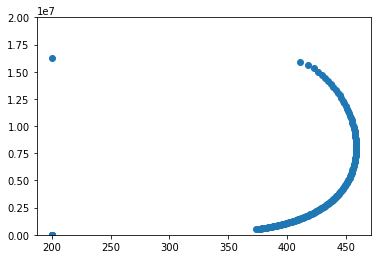

ok


In [37]:
plt.scatter(T,P_grid)
plt.ylim(0,2e7)
plt.show()
print('ok')
T1=T.copy()
P_grid1=P_grid.copy()

In [38]:
T=283.
P=30e5


#P_grid = np.linspace(5e5,90e5,500)
ngrid=300
P_grid2 = np.zeros(ngrid)
iterations2 = np.zeros(ngrid)
BETA = 0 #0.010
T_guess = 200

P_grid2[0] = 5e5
P_grid2[1] = 5.5e5

delta_T = 2

x2 = np.zeros([ngrid,Ncomp])
y2 = np.zeros([ngrid,Ncomp])
T2 = np.ones(ngrid)*200

K = np.exp(np.log(pc/P)+5.373*(1.+w)*(1.-tc/T_guess))


ans = flash_PBeta(T_guess,P_grid2[0],zgas,BETA,K,Ncomp,eosPR)
x2[0,:] = ans[0]
y2[0,:] = ans[1] 
K_old_old = ans[2]
T2[0] = ans[3]
iterations2[0] = ans[4]

T_guess = T2[0]

ans = flash_PBeta(T_guess,P_grid2[1],zgas,BETA,K_old_old,Ncomp,eosPR)
x2[1,:] = ans[0]
y2[1,:] = ans[1] 
K_old = ans[2]
T2[1] = ans[3]
iterations2[1] = ans[4]

T_guess = T2[1]

print('ok')

ok


In [39]:
for i in range(len(P_grid2)-2):
    #P_grid2[i+2] = P_grid2[i+1] + (P_grid2[i+1] - P_grid2[i])*(delta_T*(9/(i+1)/(T2[i+1]-T2[i])))
    P_grid2[i+2] = P_grid2[i+1]*1.02
    K = K_old + (K_old - K_old_old)*delta_T*(9/(i+1))/(T2[i+1]-T2[i])
    try:
        ans = flash_PBeta(T_guess,P_grid2[i+2],z,BETA,K,ncomp,eos)
    except Exception as e:
        print('finished diagram with: ', e)
        break
    x2[i+2,:] = ans[0]
    y2[i+2,:] = ans[1]
    K_old_old = K_old 
    K_old = ans[2]
    T2[i+2] = ans[3]
    iterations2[i+2] = ans[4]
    T_guess = T2[i+2]
     
#     print(P_grid2[i+2],T2[i+2],np.log(K_old),iterations2[i+2])


    print(i/(len(P_grid2)-2-1) * 100, '%')
print('ok')

0.0 %
0.33670033670033667 %
0.6734006734006733 %
1.0101010101010102 %
1.3468013468013467 %
1.6835016835016834 %
2.0202020202020203 %
2.356902356902357 %
2.6936026936026933 %
3.0303030303030303 %
3.3670033670033668 %
3.7037037037037033 %
4.040404040404041 %
4.377104377104377 %
4.713804713804714 %
5.05050505050505 %
5.387205387205387 %
5.723905723905724 %
6.0606060606060606 %
6.397306397306397 %
6.7340067340067336 %
7.07070707070707 %
7.4074074074074066 %
7.744107744107744 %
8.080808080808081 %
8.417508417508419 %
8.754208754208754 %
9.090909090909092 %
9.427609427609427 %
9.764309764309765 %
10.1010101010101 %
10.437710437710438 %
10.774410774410773 %
11.11111111111111 %
11.447811447811448 %
11.784511784511785 %
12.121212121212121 %
12.457912457912458 %
12.794612794612794 %
13.131313131313133 %
13.468013468013467 %
13.804713804713806 %
14.14141414141414 %
14.47811447811448 %
14.814814814814813 %
15.151515151515152 %
15.488215488215488 %
15.824915824915825 %
16.161616161616163 %
16.49831

/mnt/storage/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in sqrt


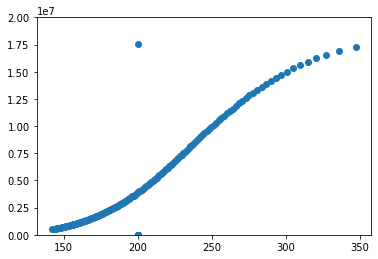

ok


In [42]:
plt.scatter(T2,P_grid2)
plt.ylim(0,2e7)
plt.show()
print('ok')

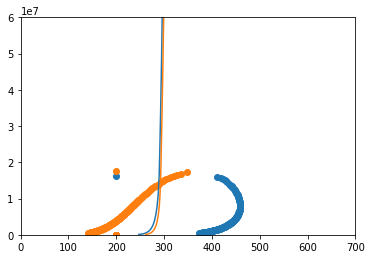

ok


In [43]:
plt.scatter(T1,P_grid1)
plt.scatter(T2,P_grid2)

plt.plot(Tgrid1,Pgrid) #hyd1
plt.plot(Tgrid2,Pgrid) #hyd2

plt.ylim(0,6e7)
plt.xlim(0,700)
plt.show()
print('ok')